# Tackling MNIST with just Numpy 

### Installing dependecies
Note: Tensorflow is imported here so that we can easily get the mnist dataset. 

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

### Loading Data and preprocessing

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print (f'x_train shape: {x_train.shape}')
print (f'y_train shape: {y_train.shape}')
print (f'y_train example: {y_train[0]}')

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
y_train example: 5


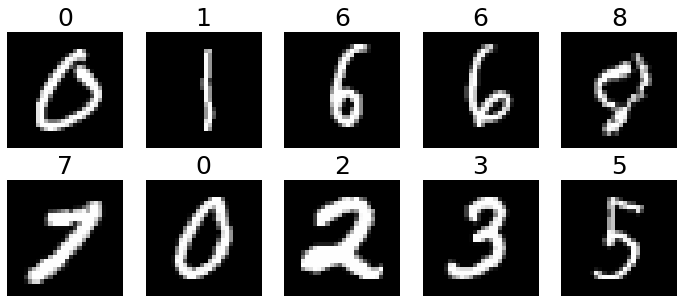

In [3]:
%matplotlib inline

fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,60000,size=10)
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [4]:
'''
Each pixel is single grayscale, meaning a value between 0 to 255.
Normalising the inputs to a value between 0 to 1 makes the calculations later on smaller.
This makes the gradient value closer to our weight initialization 
'''

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_train = x_train/255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
x_test = x_test/255

def one_hot_encode_array(y:np.array):
    '''Hot encodes the output examples.'''
    hot_encoded = np.zeros([y.shape[0],10 ])
    for i, x in enumerate(y):
        hot_encoded[i][x] = 1
    return hot_encoded

y_train = one_hot_encode_array(y_train)
y_test = one_hot_encode_array(y_test)

In [5]:
'''
Softmax is an interesting function.
Please read https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/ for an indepth analysis on it and its derivatives.

'''
def softmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x,axis=0)
    exps = np.exp(shiftx)
    return exps / np.sum(exps,axis=0)

def d_softmax(z):
    """Computes the gradient of the softmax function.
    z: (T, 1) array of input values where the gradient is computed. T is the
       number of output classes.
    Returns D (T, T) the Jacobian matrix of softmax(z) at the given z. D[i, j]
    is DjSi - the partial derivative of Si w.r.t. input j.
    """
    Sz = softmax(z)
    # -SjSi can be computed using an outer product between Sz and itself. Then
    # we add back Si for the i=j cases by adding a diagonal matrix with the
    # values of Si on its diagonal.
    D = -np.outer(Sz, Sz) + np.diag(Sz.flatten())
    return D

def relu(x):
    x[x<0] = 0
    return x 

def d_relu(x):
    return x >0

def forward_pass(a_0, w_1, w_2):
    z_1 = w_1 @ a_0   #   N1 x 784 * 784 x m  = N1 x m
    a_1 = relu(z_1) #  N1 x m 
    z_2 = w_2 @ a_1 #  10 x N1 * N1 x m  = 10 x m
    a_2 = softmax(z_2) # 10 x m
    return z_1,a_1, z_2 ,a_2

def cross_entropy_loss(a_2, y):
    """Cross-entropy loss between predicted and expected probabilities.
    p: vector of predicted probabilities.
    y: vector of expected probabilities. Has to be the same shape as p.
    Returns a scalar.
    """
    assert(a_2.shape == y.shape)
    return -np.sum(y * np.log(a_2))

def d_cross_entropy_loss(a_2, y):
    """Gradient of the cross-entropy loss function for p and y.
    p: (T, 1) vector of predicted probabilities.
    y: (T, 1) vector of expected probabilities; must be one-hot -- one and only
              one element of y is 1; the rest are 0.
    Returns a (1, T) Jacobian for this function.
    """
    assert(a_2.shape == y.shape and a_2.shape[1] == 1)
    # py is the value of p at the index where y == 1 (one and only one such
    # index is expected for a one-hot y).
    py = a_2[y == 1]
    assert(py.size == 1)
    # D is zeros everywhere except at the index where y == 1. The final D has
    # to be a row-vector.
    D = np.zeros_like(a_2)
    D[y == 1] = -1/py.flat[0]
    return D.flatten().reshape(-1,1)
    
def backward_pass(a_0, z_1,a_1, z_2 ,a_2, w_1,w_2, Y):
    # Backward pass, differenciate wrt Cost function.
    d_a2 =  d_cross_entropy_loss(a_2, Y) # 10 x m
    d_z2 =   d_softmax(z_2) @ d_a2 # 10 x m 
    d_w2 = d_z2 @ a_1.T # 10 x m * m x N1 = 10 x N1
 
    d_a1 = w_2.T @ d_z2 # N1 x 10  * 10 x m  = N1 x m
    d_z1 = d_a1 * d_relu(z_1) # N1 x m   N1 x m = N1 x m
    d_w1 = d_z1 @ a_0.T # N1 x m * m x 784 = N1 x 784

    assert d_w1.shape == w_1.shape, f'{d_w1.shape} {w_1.shape}'
    assert d_w2.shape == w_2.shape, f'{d_w2.shape} {w_2.shape}'

    return  d_w1 , d_w2

def update_weights(w_1,w_2, d_w1 , d_w2, learning_rate):
    w_1 = w_1 - learning_rate*d_w1 
    w_2 = w_2 - learning_rate*d_w2
    return w_1, w_2

In [6]:
def gradient_descent(X, Y, w_1, w_2 , epochs = 1, learning_rate=0.001):
    for i in range(epochs):
        for x,y in zip(X, Y):
            a_0 = x.reshape(-1,1)
            y = y.reshape(-1,1)
            z_1, a_1, z_2 ,a_2 = forward_pass(a_0, w_1, w_2)
            print(cross_entropy_loss(a_2,y))
            d_w1 , d_w2 = backward_pass(a_0, z_1,a_1, z_2 ,a_2, w_1,w_2, y)
            w_1, w_2 = update_weights(w_1,w_2, d_w1,d_w2,learning_rate)

    return w_1,w_2

def get_prediction(a_2):
    return np.argmax(a_2.T)

def check_accuracy(X,Y ,w_1,w_2):
    a_0 = X.T
    z_1,a_1, z_2 ,a_2 = forward_pass(a_0, w_1, w_2)
    return a_2

In [7]:
neurons = 256
epochs = 1
learning_rate = 0.0001
w_1 = np.random.rand(neurons,784)
w_2 = np.random.rand(10, neurons)

In [8]:
w_1,w_2 = gradient_descent(x_train, y_train, w_1, w_2, epochs, learning_rate)

278.5638496366573
45.31715294285789
213.93374951123374
21.19949461079002
97.76764478382847
560.207640922586
25.039417938979955
149.69677004645746
57.22068307424689
174.35709847419182
49.156923438536545
68.44343365357281
-0.0
36.15186865960396
34.98573118155518
80.03986769211497
376.26900450326826
338.1970295591127
13.78627601651301
33.55532958571674
112.21028710462157
57.68147260503541
77.89217072401334
35.723087950620084
2.2204460492503154e-15
480.05738758143343
20.578303967201002
96.61740395296147
450.4901991301849
26.78533721824218
25.389144453185278
295.02854642056536
48.69644254850461
46.023887390141745
22.414155468940134
87.80241690302773
114.6345644908015
94.56123705084246
85.50140009106326
70.9299084180206
32.36006319180163
122.5190247181233
35.377839076014794
50.828116530059745
20.120872832330026
38.8352520029845
80.24900139333658
55.74453231551706
11.25049474509181
113.87459425071029
-0.0
151.42493422039843
106.09156440986771
66.67546015430294
77.83159208270466
44.56509937145

In [9]:
output = check_accuracy(x_test,y_test,w_1,w_2)
np.argmax(output, axis=0)

array([7, 2, 1, ..., 9, 8, 6], dtype=int64)

In [10]:
np.argmax(y_test,axis=1)

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)